In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from acgan import torch_gan
%matplotlib inline

import torch.utils.data
import torchvision.datasets as dset

import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt

import numpy as np

/home/morgan/venv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from acgan import torch_vae

## Fashion MNIST

In [3]:
# Root directory for dataset
dataroot = "~/datasets"

image_size = 28
batch_size = 128
workers = 4
depth = 1

dataset = dset.FashionMNIST(dataroot, train=True, 
                            transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]), 
                            
                            target_transform=None, download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=100*batch_size),
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))

In [4]:
n_samples = int(np.round(dataloader.sampler.num_samples/ dataloader.batch_size))

vae_trainer = torch_vae.VAETrainer(model=torch_vae.VAE(input_size=image_size**2), data_gen=dataloader, n_samples=n_samples)

In [8]:
loss_hist = vae_trainer.train(10)

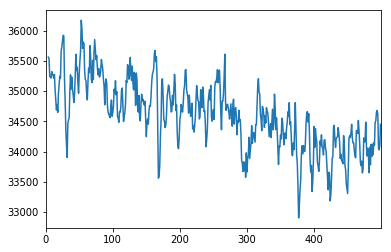

In [12]:
import pandas as pd
pd.Series(loss_hist).rolling(5).mean().plot()

****

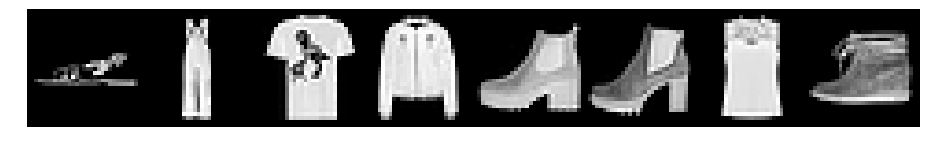

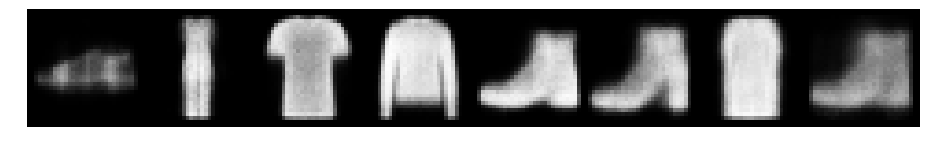

In [9]:
torch_gan.GANTrainer.grid_display(real_batch[0][:8], figsize=(16, 16));
torch_gan.GANTrainer.grid_display(vae_trainer.model(real_batch[0][:8])[0].reshape(-1, depth, image_size, image_size), 
                                  figsize=(16, 16));

## Celeb Faces

In [ ]:
device='cpu'
dataroot = '/export/datasets/celeba'

image_size = 64
batch_size = 64
workers = 4
depth =3

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Random Sampling dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=1000*batch_size),
                                         shuffle=False,
                                         num_workers=workers)
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))

In [ ]:
n_samples = int(np.round(dataloader.sampler.num_samples/ dataloader.batch_size))

vae_trainer = torch_vae.VAETrainer(model=torch_vae.VAE(input_size=64**2), data_gen=dataloader, n_samples=n_samples)

In [ ]:
vae_trainer.train(3)